# Prepare

Import some libraries

In [1]:
from IPython.core.interactiveshell import InteractiveShell
import json
import os, re
import pandas as pd
import numpy as np
import time
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import ast
import math
from jupyterthemes import jtplot

jtplot.style(theme='chesterish')

Define important methods

In [2]:
def load_jsonl(jsonl):
    with open(jsonl, 'r') as file:
        return [json.loads(line) for line in list(file)]


def load_json(file):
    with open(file, 'r') as f:
        return json.load(f)

In [3]:
def make_string(d, use=['context', 'question', 'answer']):
    res = []
    if 'context' in use:
        res.append("Context: " + d['context'])
    if 'question' in use:
        res.append("Question: " + d['question'])
    if 'answer' in use:
        res.append("Answer: " + d['answer'])
    return ' [SEP] '.join(res) + ' [SEP]'

In [4]:
def make_dataset(d):
    X, y = [], []
    for i in simplify_data(d, remove_number=True):
        X.append(make_string(i))
        y.append(i['label'])
    return X, y

In [5]:
def save_predictions(predictions, filename="solution"):
    test=load_jsonl('data/test.jsonl')
    if '.jsonl' not in filename:
        filename += ".jsonl"
        
    counter = 0
    for item in test:
        del item['passage']['text']
        for question in item['passage']['questions']:
            del question['question']
            for answer in question['answers']:
                del answer['text']
                answer['label'] = int(predictions[counter])
                counter += 1
                
    with open(filename, 'w') as file:
        for line in test:
            file.write(json.dumps(line) + '\n')
    print("call me", filename)

# Load

In [6]:
raw_validation, raw_train, raw_test = load_jsonl('data/val.jsonl'), load_jsonl(
    'data/train.jsonl'), load_jsonl('data/test.jsonl')

In [7]:
for corpus in raw_validation + raw_train:
    corpus['is_answered'] = True
for corpus in raw_test:
    corpus['is_answered'] = False

In [8]:
data = raw_train + raw_validation + raw_test

Восстанавливаем индексы

In [9]:
context_index = 0
question_index = 0
answer_index = 0
for idx, item in enumerate(data):
    item['old_idx'] = item['idx']
    item['idx'] = context_index
    context_index += 1
    for q in item['passage']['questions']:
        q['old_idx'] = q['idx']
        q['idx'] = question_index
        question_index += 1
        for answer in q['answers']:
            answer['old_idx'] = answer['idx']
            answer['idx'] = answer_index
            answer_index += 1

# Analyse

In [10]:
amounts = {}
for i in data:
    if i['is_answered']:
        for question in i['passage']['questions']:
            right_answers_amount = sum(
                map(lambda answer: answer['label'], question['answers']))
            if right_answers_amount in amounts:
                amounts[right_answers_amount] += 1
            else:
                amounts[right_answers_amount] = 0

Text(0, 0.5, 'Amount')

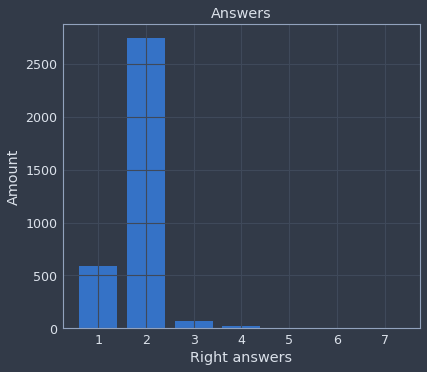

In [11]:
x = amounts.keys()
y = amounts.values()
plt.bar(x, y)
plt.title("Answers")
plt.xlabel("Right answers")
plt.ylabel("Amount")

In [12]:
fractions = {}
for i in data:
    if i['is_answered']:
        for question in i['passage']['questions']:
            fraction = sum(
                map(lambda answer: answer['label'],
                    question['answers'])) / len(question['answers'])
            if fraction in fractions:
                fractions[fraction] += 1
            else:
                fractions[fraction] = 0

Text(0, 0.5, 'Amount')

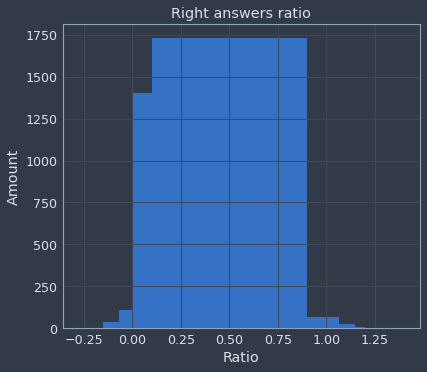

In [13]:
x = fractions.keys()
y = fractions.values()
plt.bar(x, y)
plt.title("Right answers ratio")
plt.xlabel("Ratio")
plt.ylabel("Amount")

import collections
pd.DataFrame(collections.Counter(list(train['answer_ru'])).most_common(10), columns=['Answer', 'Amount']).set_index('Answer').plot(kind='barh')

# Translate

Load translation dictionaries

In [14]:
translated_answers, translated_questions, translated_texts = load_json(
    'data/answers.json'), load_json('data/questions.json'), load_json(
        'data/texts.json')

In [15]:
translated_questions[
    'Почему медвежонок решил уйти из дома?'] = "Why did the teddy bear decide to leave home?"

In [16]:
def translate(text, kind='text'):
    if kind == 'text':
        return translated_texts[text]
    elif kind == 'question':
        return translated_questions[text]
    elif kind == 'answer':
        return translated_answers[text]

Translate data

In [17]:
for item in data:
    passage = item['passage']
    questions = passage['questions']
    passage['text_en'] = translate(passage['text'], kind='text')
    for question_idx, question in enumerate(questions):
        questions[question_idx]['question_en'] = translate(
            question['question'], kind='question')
        answers = question['answers']
        for answer_idx, answer in enumerate(answers):
            answers[answer_idx]['text_en'] = translate(answer['text'],
                                                       kind='answer')

# Make flatten

In [18]:
def remove_sentence_number(s):
    return re.sub('\(\d+\)[ ]*', '', s)

In [19]:
def simplify_data(d, split_answers=False, split_questions=True, use_en=True):
    simplified = []
    temp = {}
    for item in d:
        temp['context_ru'] = remove_sentence_number(item['passage']['text'])
        if use_en:
            temp['context_en'] = remove_sentence_number(item['passage']['text_en'])
        temp['context_idx'] = item['idx']
        temp['context_old_idx'] = item['old_idx']
        temp['is_answered'] = item['is_answered']
        if split_questions:
            for question in item['passage']['questions']:
                temp['question_ru'] = question['question']
                if use_en:
                    temp['question_en'] = question['question_en']
                temp['question_idx'] = question['idx']
                temp['question_old_idx'] = question['old_idx']
                if split_answers:
                    for answer in question['answers']:
                        temp['answer_ru'] = answer['text']
                        if use_en:
                            temp['answer_en'] = answer['text_en']
                        temp['answer_idx'] = answer['idx']
                        temp['answer_old_idx'] = answer['old_idx']
                        temp['label'] = answer[
                            'label'] if 'label' in answer else None
                        simplified.append(temp.copy())
                else:
                    temp['answers'] = question['answers']
                    simplified.append(temp.copy())
        else:
            temp['questions'] = item['passage']['questions']
            simplified.append(temp.copy())
    return simplified

In [20]:
train = pd.DataFrame(list(simplify_data(data, split_answers=True)))

In [21]:
train.head()

,context_ru,context_en,context_idx,context_old_idx,is_answered,question_ru,question_en,question_idx,question_old_idx,answer_ru,answer_en,answer_idx,answer_old_idx,label
0,"Но люди не могут существовать без природы, поэ...","But people cannot exist without nature, so the...",0,0,True,Где бегала шпана?,Where did the punks run?,0,0,В парке.,In the park.,0,0,1.0
1,"Но люди не могут существовать без природы, поэ...","But people cannot exist without nature, so the...",0,0,True,Где бегала шпана?,Where did the punks run?,0,0,В лесу.,In the woods.,1,1,0.0
2,"Но люди не могут существовать без природы, поэ...","But people cannot exist without nature, so the...",0,0,True,Где бегала шпана?,Where did the punks run?,0,0,Около подъезда.,Near the entrance.,2,2,0.0
3,"Но люди не могут существовать без природы, поэ...","But people cannot exist without nature, so the...",0,0,True,Почему Люда ударила Артема?,Why did Luda hit Artyom?,1,1,Он к ней приставал.,He pestered her.,3,3,1.0
4,"Но люди не могут существовать без природы, поэ...","But people cannot exist without nature, so the...",0,0,True,Почему Люда ударила Артема?,Why did Luda hit Artyom?,1,1,Он ее оскорбил.,He insulted her.,4,4,0.0


# Yammy Features

## General

In [22]:
def harmonic_mean(arr):
    n = len(arr)
    if n == 0:
        return 0
    s = 0
    for i in arr:
        if i == 0:
            i = 10 ** -10
        s += 1 / i
    return n / s if s != 0 else 10 ** -10


def geometric_mean(arr):
    n = len(arr)
    if n == 0:
        return 0
    res = 1
    for i in arr:
        res = res * (i**(1 / n))
    return res


def square_mean(arr):
    n = len(arr)
    if n == 0:
        return 0
    s = 0
    for i in arr:
        s += i * i
    return math.sqrt(s / n)


def mmmm(feature, where=None, by=None, function=None):
    if where is None:
        where = train
    if by == 'context_idx':
        return where
    assert by != None, 'Missing required \'by\' parameter!'
    temp = where[[feature, by]].groupby([by]).agg(
        ['mean', 'std', 'median', 'max', 'min', 'sum', square_mean, geometric_mean, harmonic_mean])
    temp.columns = [
        '_'.join(col).strip() + '_by_' + by.split('_')[0]
        for col in temp.columns.values
    ]
    return pd.merge(temp, where, on=by)

## Dumb features

Make set of answers for the question and tuple of qustions on the text.

In [23]:
temp = {'questions_set': [], 'answers_tuple': []}
for corpus in simplify_data(data, split_questions=False):
    questions = corpus['questions']
    for question in questions:
        answers = question['answers']
        for answer in answers:
            temp['questions_set'].append(
                list(map(lambda x: x['idx'], questions)))
            temp['answers_tuple'].append(list(map(lambda x: x['idx'],
                                                  answers)))
train['questions_set'] = temp['questions_set']
train['answers_tuple'] = temp['answers_tuple']

Dumb words counting

In [24]:
for feature in ['context', 'question', 'answer']:
    for locale in ['ru', 'en']:
        train['words_amount_in_' + feature + '_' + locale] = [
            t.count(' ') + 1 for t in train[feature + '_' + locale]
        ]

In [25]:
for feature in ['context', 'question', 'answer']:
    train['words_amount_in_' + feature +
          '_difference'] = train['words_amount_in_' + feature +
                                 '_ru'] - train['words_amount_in_' + feature +
                                                '_en']

In [26]:
for feature in ['answer']:
    for locale in ['ru', 'en']:
        for by in ['question_idx', 'context_idx']:
            train = mmmm('words_amount_in_' + feature + '_' + locale, by=by)

In [27]:
for feature in ['question']:
    for locale in ['ru', 'en']:
        for by in ['context_idx']:
            train = mmmm('words_amount_in_' + feature + '_' + locale, by=by)

In [28]:
train.head(2)

,question_idx,words_amount_in_answer_en_mean_by_question,words_amount_in_answer_en_std_by_question,words_amount_in_answer_en_median_by_question,words_amount_in_answer_en_max_by_question,words_amount_in_answer_en_min_by_question,words_amount_in_answer_en_sum_by_question,words_amount_in_answer_en_square_mean_by_question,words_amount_in_answer_en_geometric_mean_by_question,words_amount_in_answer_en_harmonic_mean_by_question,...,answers_tuple,words_amount_in_context_ru,words_amount_in_context_en,words_amount_in_question_ru,words_amount_in_question_en,words_amount_in_answer_ru,words_amount_in_answer_en,words_amount_in_context_difference,words_amount_in_question_difference,words_amount_in_answer_difference
0,0,3.0,0.0,3.0,3,3,9,3.0,3.0,3.0,...,"[0, 1, 2]",161,224,3,5,2,3,-63,-2,-1
1,0,3.0,0.0,3.0,3,3,9,3.0,3.0,3.0,...,"[0, 1, 2]",161,224,3,5,2,3,-63,-2,-1


Amount of qustions and answers

In [29]:
train['answers_amount'] = [len(t) for t in train['answers_tuple']]
train['quesitons_amount'] = [len(t) for t in train['questions_set']]

In [30]:
train = mmmm('answers_amount', by='context_idx')

In [31]:
train.head(2)

,question_idx,words_amount_in_answer_en_mean_by_question,words_amount_in_answer_en_std_by_question,words_amount_in_answer_en_median_by_question,words_amount_in_answer_en_max_by_question,words_amount_in_answer_en_min_by_question,words_amount_in_answer_en_sum_by_question,words_amount_in_answer_en_square_mean_by_question,words_amount_in_answer_en_geometric_mean_by_question,words_amount_in_answer_en_harmonic_mean_by_question,...,words_amount_in_context_en,words_amount_in_question_ru,words_amount_in_question_en,words_amount_in_answer_ru,words_amount_in_answer_en,words_amount_in_context_difference,words_amount_in_question_difference,words_amount_in_answer_difference,answers_amount,quesitons_amount
0,0,3.0,0.0,3.0,3,3,9,3.0,3.0,3.0,...,224,3,5,2,3,-63,-2,-1,3,9
1,0,3.0,0.0,3.0,3,3,9,3.0,3.0,3.0,...,224,3,5,2,3,-63,-2,-1,3,9


## Zeroshot

Good-old zero-shot cls

In [32]:
facebook_mnli = pd.read_csv('data/facebook_mnli.csv').rename(
    columns={
        'Unnamed: 0': 'answer_idx'
    }).set_index('answer_idx')

In [33]:
facebook_mnli.head()

,facebook_mnli
answer_idx,
0,0.876531
1,0.042271
2,0.081198
3,0.836539
4,0.145226


In [34]:
train = pd.merge(train, facebook_mnli, on='answer_idx')

In [35]:
train = mmmm('facebook_mnli', by='question_idx')
train = mmmm('facebook_mnli', by='context_idx')

## Tokenizing

Tokenizing fetish

In [36]:
!pip install nltk

In [37]:
import nltk
nltk.download("stopwords")
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [38]:
stemmers = {'ru': SnowballStemmer('russian'), 'en': PorterStemmer()}

In [39]:
stop_words = {'ru': set(stopwords.words("russian")), 'en': set(stopwords.words("english"))}

In [40]:
tokenize = lambda text: nltk.word_tokenize(text)

In [41]:
stemmerize = lambda text, locale: set([stemmers[locale].stem(word) for word in nltk.word_tokenize(text) if not word.lower() in stop_words[locale] and word[0].isalpha()])

In [42]:
stemmed = {}

for locale in tqdm(['en', 'ru']):
    temp = []
    for corpus in simplify_data(data, split_questions=False):
        words_in_context = stemmerize(corpus['context_' + locale], locale)
        for question in corpus['questions']:
            words_in_question = stemmerize(question['question' + ('_en' if locale == 'en' else '')], locale)
            for answer in question['answers']:
                words_in_answer = stemmerize(answer['text' + ('_en' if locale == 'en' else '')], locale)
                temp.append({'stemmed_context_' + locale: words_in_context, 
                             'stemmed_question_' + locale: words_in_question, 
                             'stemmed_answer_' + locale: words_in_answer})
    stemmed[locale] = temp

In [43]:
train = pd.concat([train, pd.DataFrame(stemmed['ru']), pd.DataFrame(stemmed['en'])], axis=1)

In [44]:
for feature in ['context', 'question', 'answer']:
    for locale in ['ru', 'en']:
        train['stems_amount_in_' + feature + '_' + locale] = [len(t) for t in train['stemmed_' + feature + '_' + locale]]

In [45]:
for locale in ['ru', 'en']:
    train = pd.concat([train, pd.DataFrame([{'same_words_answer_question_' + locale: len(a & q), 
      'same_words_context_quesiton_' + locale: len(q & c), 
      'same_words_context_answer_' + locale: len(a & c)} for c, q, a in train[['stemmed_context_' + locale, 'stemmed_question_' + locale, 'stemmed_answer_' + locale]].values])], axis=1)

In [46]:
train.head()

,question_idx,facebook_mnli_mean_by_question,facebook_mnli_std_by_question,facebook_mnli_median_by_question,facebook_mnli_max_by_question,facebook_mnli_min_by_question,facebook_mnli_sum_by_question,facebook_mnli_square_mean_by_question,facebook_mnli_geometric_mean_by_question,facebook_mnli_harmonic_mean_by_question,...,stems_amount_in_question_ru,stems_amount_in_question_en,stems_amount_in_answer_ru,stems_amount_in_answer_en,same_words_answer_question_ru,same_words_context_quesiton_ru,same_words_context_answer_ru,same_words_answer_question_en,same_words_context_quesiton_en,same_words_context_answer_en
0,0,0.333333,0.470826,0.081198,0.876531,0.042271,1.0,0.508818,0.144362,0.080834,...,2,2,1,1,0,2,1,0,2,1
1,0,0.333333,0.470826,0.081198,0.876531,0.042271,1.0,0.508818,0.144362,0.080834,...,2,2,1,1,0,2,0,0,2,0
2,0,0.333333,0.470826,0.081198,0.876531,0.042271,1.0,0.508818,0.144362,0.080834,...,2,2,2,2,0,2,0,0,2,0
3,1,0.333333,0.440390,0.145226,0.836539,0.018235,1.0,0.490313,0.130361,0.047680,...,4,3,1,1,0,1,0,0,1,0
4,1,0.333333,0.440390,0.145226,0.836539,0.018235,1.0,0.490313,0.130361,0.047680,...,4,3,1,1,0,1,0,0,1,0


In [47]:
for feature in ['answer']:
    for locale in ['ru', 'en']:
        train['stems_same_stems_ratio_' + feature + '_' + locale] = train['stems_amount_in_' + feature + '_' + locale] / train['stems_amount_in_' + feature + '_' + locale]

In [48]:
for locale in ['ru', 'en']:
    for feature in ['same_words_answer_question', 'same_words_context_quesiton', 'same_words_context_answer', 'stems_same_stems_ratio_answer']:
        train = mmmm(feature + '_' + locale, by='question_idx')
        train = mmmm(feature + '_' + locale, by='context_idx')

In [49]:
train.head()

,question_idx,stems_same_stems_ratio_answer_en_mean_by_question,stems_same_stems_ratio_answer_en_std_by_question,stems_same_stems_ratio_answer_en_median_by_question,stems_same_stems_ratio_answer_en_max_by_question,stems_same_stems_ratio_answer_en_min_by_question,stems_same_stems_ratio_answer_en_sum_by_question,stems_same_stems_ratio_answer_en_square_mean_by_question,stems_same_stems_ratio_answer_en_geometric_mean_by_question,stems_same_stems_ratio_answer_en_harmonic_mean_by_question,...,stems_amount_in_answer_ru,stems_amount_in_answer_en,same_words_answer_question_ru,same_words_context_quesiton_ru,same_words_context_answer_ru,same_words_answer_question_en,same_words_context_quesiton_en,same_words_context_answer_en,stems_same_stems_ratio_answer_ru,stems_same_stems_ratio_answer_en
0,0,1.0,0.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,...,1,1,0,2,1,0,2,1,1.0,1.0
1,0,1.0,0.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,...,1,1,0,2,0,0,2,0,1.0,1.0
2,0,1.0,0.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,...,2,2,0,2,0,0,2,0,1.0,1.0
3,1,1.0,0.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,...,1,1,0,1,0,0,1,0,1.0,1.0
4,1,1.0,0.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,...,1,1,0,1,0,0,1,0,1.0,1.0


## Encoding

QABert via roberta

In [50]:
robert = pd.read_csv('data/original_bert_answers_similarity_by_roberta.csv').set_index('Unnamed: 0')

In [51]:
robert.columns = ['original_bert_answers_similarity_by_roberta_top_' + column for column in robert.columns]

In [52]:
robert[['original_bert_answers_similarity_by_roberta_min',
       'original_bert_answers_similarity_by_roberta_max',
       'original_bert_answers_similarity_by_roberta_mean',
       'original_bert_answers_similarity_by_roberta_median',
       'original_bert_answers_similarity_by_roberta_std']] = pd.DataFrame([[np.min(value), np.max(value), np.mean(value), np.median(value), np.std(value)] for value in robert.values])

QARoberta via USE

In [53]:
rouse = pd.read_csv('data/original_roberta_answers_similarity_by_use.csv').set_index('Unnamed: 0')

In [54]:
rouse['original_roberta_answers_similarity_by_use'] = [ast.literal_eval(value) for value in rouse['original_roberta_answers_similarity_by_use']]

In [55]:
rouse = pd.DataFrame(list(rouse['original_roberta_answers_similarity_by_use']))

In [56]:
rouse.columns = ['original_roberta_answers_similarity_by_use_top_' + str(column) for column in rouse.columns]

In [57]:
rouse[['original_roberta_answers_similarity_by_use_min',
       'original_roberta_answers_similarity_by_use_max',
       'original_roberta_answers_similarity_by_use_mean',
       'original_roberta_answers_similarity_by_use_median',
       'original_roberta_answers_similarity_by_use_std']] = pd.DataFrame([[np.min(value), np.max(value), np.mean(value), np.median(value), np.std(value)] for value in rouse.values])

QABert via USE

In [58]:
bertuse = pd.read_csv('data/original_bert_answers_similarity_by_use.csv').set_index('Unnamed: 0')

In [59]:
bertuse['original_bert_answers_similarity_by_use'] = [ast.literal_eval(value) for value in bertuse['original_bert_answers_similarity_by_use']]

In [60]:
bertuse = pd.DataFrame(list(bertuse['original_bert_answers_similarity_by_use']))

In [61]:
bertuse.columns = ['original_bert_answers_similarity_by_use_top_' + str(column) for column in bertuse.columns]

In [62]:
bertuse[['original_bert_answers_similarity_by_use_min',
       'original_bert_answers_similarity_by_use_max',
       'original_bert_answers_similarity_by_use_mean',
       'original_bert_answers_similarity_by_use_median',
       'original_bert_answers_similarity_by_use_std']] = pd.DataFrame([[np.min(value), np.max(value), np.mean(value), np.median(value), np.std(value)] for value in bertuse.values])

QAT5 via Roberta

In [63]:
t5berta = pd.read_csv('data/original_t5_answers_similarity_by_roberta.csv').set_index('Unnamed: 0')

In [64]:
t5berta.columns = ['original_t5_answers_similarity_by_roberta'] 

QAT5 via USE

In [65]:
t5use = pd.read_csv('data/original_t5_answers_similarity_by_use.csv').set_index('Unnamed: 0')

In [66]:
t5use.columns = ['original_t5_answers_similarity_by_use'] 

QAT5-3B via Roberta

In [67]:
t53bberta = pd.read_csv('data/original_t5-3b_answers_similarity_by_roberta.csv').set_index('Unnamed: 0')

In [68]:
t53bberta.columns = ['original_t5-3b_answers_similarity_by_roberta'] 

Context answers via Roberta

In [69]:
contextberta = pd.read_csv('data/context_answers_encoding_distance_by_roberta.csv').set_index('Unnamed: 0')

In [70]:
contextberta.columns = ['context_answers_encoding_distance_by_roberta'] 

Sentences via Roverta

In [71]:
sentenceberta = pd.read_csv('data/sentence_answer_similarity_by_roberta.csv').set_index('Unnamed: 0')

Concat all and make mmmm

In [72]:
train = pd.concat([train, bertuse, rouse, robert, t5berta, t5use, t53bberta, contextberta, sentenceberta], axis=1)

In [73]:
for column in tqdm(list(bertuse.columns) + list(sentenceberta.columns) + list(contextberta.columns) + list(t53bberta.columns) + list(rouse.columns) + list(robert.columns) + list(t5berta.columns) + list(t5use.columns)):
    train = mmmm(column, by='question_idx')
    train = mmmm(column, by='context_idx')

/opt/conda/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:252: ComplexWarning: Casting complex values to real discards the imaginary part
  return result.astype(dtype)


In [74]:
train['magic_scores'] = list(np.load('data/T5LargeProbs_train.npy')) + list(np.load('data/T5LargeProbs_val.npy')) + list(np.load('data/T5LargeProbs_test.npy'))

In [75]:
train['magic_numbers_LC'] = list(np.load('data/rawT5noHTMLtrainLC.npy')) + list(np.load('data/rawT5noHTMLvalLC.npy')) + list(np.load('data/rawT5noHTMLtestLC.npy'))

In [76]:
train['magic_numbers'] = list(np.load('data/rawT5noHTMLtrain.npy')) + list(np.load('data/rawT5noHTMLval.npy')) + list(np.load('data/rawT5noHTMLtest.npy'))

In [77]:
train['magic_scores_LC'] = list(np.load('data/T5LargeProbs_train_RC.npy')) + list(np.load('data/T5LargeProbs_val_RC.npy')) + list(np.load('data/T5LargeProbs_test_RC.npy'))

In [78]:
train['super_magic_numbers'] = list(np.load('data/t5_11b_train.npy')) + list(np.load('data/t5-11b_val.npy')) + list(np.load('data/t5_11b_test.npy'))

In [79]:
train['super_magic_numbers_scores'] = list(np.load('data/t5_11b_probs_train.npy')) + list(np.load('data/t5-11b_probs_val.npy')) + list(np.load('data/t5_11b_probs_test.npy'))

In [80]:
train = mmmm('magic_numbers', by='question_idx')
train = mmmm('magic_numbers', by='context_idx')
train = mmmm('magic_numbers_LC', by='question_idx')
train = mmmm('magic_numbers_LC', by='context_idx')
train = mmmm('magic_scores', by='question_idx')
train = mmmm('magic_scores', by='context_idx')
train = mmmm('magic_scores_LC', by='question_idx')
train = mmmm('magic_scores_LC', by='context_idx')
train = mmmm('super_magic_numbers', by='question_idx')
train = mmmm('super_magic_numbers', by='context_idx')
train = mmmm('super_magic_numbers_scores', by='question_idx')
train = mmmm('super_magic_numbers_scores', by='context_idx')

In [81]:
FULL_DATASET = pd.concat([pd.read_csv('data/FULLTRAIN.csv'), pd.read_csv('data/FULLVAL.csv'), pd.read_csv('data/FULLTEST.csv')]).reset_index().drop(columns=['t5preds', 'Unnamed: 0', 'index'])
train = pd.concat([train, FULL_DATASET], axis=1)

In [ ]:
for column in tqdm(unknown_columns):
    train = mmmm(column, by='question_idx')
    train = mmmm(column, by='context_idx')

In [ ]:
train = pd.read_csv('part_train.csv').drop(columns=['Unnamed: 0'])

In [ ]:
train = pd.read_csv('VERYFULLTRAIN.csv').drop(columns=['Unnamed: 0'])

In [ ]:
train['answers_tuple'] = [ast.literal_eval(i) for i in train['answers_tuple'].values]

# CatBoost Forever!

In [76]:
!pip install sklearn
!pip install catboost

In [45]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import f1_score, accuracy_score

In [183]:
temp = train.set_index('answer_idx').drop(columns=['context_idx', 'question_idx', 
                                          'questions_set', 'answers_tuple', 
                                          'context_old_idx', 'question_old_idx', 'answer_old_idx',
                                          'stemmed_context_ru', 'stemmed_context_en', 
                                          'stemmed_question_ru', 'stemmed_question_en', 
                                          'stemmed_answer_ru', 'stemmed_answer_en', 'is_answered',
                                          'context_ru', 'context_en', 'question_ru', 'question_en', 'answer_ru', 'answer_en'])

In [184]:
ttrain, validation = temp[train['is_answered'] == True], temp[train['is_answered'] == False]

In [185]:
X_train, y_train = ttrain.drop(columns=['label']), ttrain['label']

In [186]:
train_size = 0.801
X_train, X_test, y_train, y_test = X_train.iloc[:int(len(X_train.index) * train_size)], X_train.iloc[int(len(X_train.index) * train_size) + 1:], y_train.iloc[:int(len(y_train.index) * train_size)], y_train.iloc[int(len(y_train.index) * train_size) + 1:] 

In [196]:
catboost_classifier = CatBoostClassifier(depth=4, iterations=750, learning_rate=0.003, eval_metric='F1')

In [197]:
catboost_classifier.fit(X_train,
          y_train,
          verbose=True, 
          eval_set=(X_test, y_test))

0:	learn: 0.7168078	test: 0.6895128	best: 0.6895128 (0)	total: 21.1ms	remaining: 15.8s
1:	learn: 0.7180287	test: 0.6994536	best: 0.6994536 (1)	total: 40.9ms	remaining: 15.3s
2:	learn: 0.7375598	test: 0.7180984	best: 0.7180984 (2)	total: 62ms	remaining: 15.4s
3:	learn: 0.7406878	test: 0.7190357	best: 0.7190357 (3)	total: 82.6ms	remaining: 15.4s
4:	learn: 0.7491719	test: 0.7427184	best: 0.7427184 (4)	total: 102ms	remaining: 15.2s
5:	learn: 0.7450030	test: 0.7254822	best: 0.7427184 (4)	total: 122ms	remaining: 15.1s
6:	learn: 0.7408222	test: 0.7233523	best: 0.7427184 (4)	total: 142ms	remaining: 15s
7:	learn: 0.7444814	test: 0.7259320	best: 0.7427184 (4)	total: 159ms	remaining: 14.8s
8:	learn: 0.7504762	test: 0.7378641	best: 0.7427184 (4)	total: 179ms	remaining: 14.7s
9:	learn: 0.7494501	test: 0.7396928	best: 0.7427184 (4)	total: 195ms	remaining: 14.5s
10:	learn: 0.7512254	test: 0.7378247	best: 0.7427184 (4)	total: 216ms	remaining: 14.5s
11:	learn: 0.7489199	test: 0.7340946	best: 0.7427184 

In [198]:
f1_score(y_test, catboost_classifier.predict(X_test)) # 0.9119295436349079

0.7819924968736973

In [199]:
accuracy_score(y_test, catboost_classifier.predict(X_test))

0.8146704464918497

In [200]:
sorted(list(zip(catboost_classifier.get_feature_importance(), X_train.columns)))[-100:]

[(0.03153750071401803,
  'original_bert_answers_similarity_by_use_top_9_square_mean_by_question'),
 (0.03417502744498837,
  'original_bert_answers_similarity_by_use_top_7_square_mean_by_question'),
 (0.03702755222430536,
  'original_bert_answers_similarity_by_use_top_6_sum_by_question'),
 (0.03763597025945289,
  'original_bert_answers_similarity_by_use_mean_min_by_question'),
 (0.03820657754201338,
  'original_bert_answers_similarity_by_use_max_min_by_question'),
 (0.03824347646238866,
  'original_bert_answers_similarity_by_use_top_7_mean_by_question'),
 (0.04051086980865091, 'words_amount_in_answer_ru_std_by_question'),
 (0.04060475895414786,
  'original_bert_answers_similarity_by_use_top_1_std_by_question'),
 (0.0408361233743744,
  'original_bert_answers_similarity_by_use_top_2_square_mean_by_question'),
 (0.04184906512331114,
  'original_bert_answers_similarity_by_use_top_2_median_by_question'),
 (0.04566233089422451, 'original_bert_answers_similarity_by_use_min'),
 (0.0506865206560

In [219]:
save_predictions(catboost_classifier.predict(validation), filename="toagng")

call me toagng.jsonl


In [213]:
def process_probabilities(data):
    temp = data
    temp = pd.concat([temp.reset_index(), pd.DataFrame(list(map(lambda x: x[1], catboost_classifier.predict_proba(temp))), columns=['predicted_probability'])], axis=1)
    temp = pd.merge(temp, train[['question_idx', 'answer_idx']], on='answer_idx')
    temp = temp.drop(columns=['answer_idx']).groupby('question_idx').agg(['mean', 'std', 'median', 'max', 'min', 'sum', square_mean, geometric_mean, harmonic_mean])
    temp.columns = ['_'.join(col).strip() for col in temp.columns.values]
    temp = pd.merge(temp, train[['question_idx']], on='question_idx', how='inner').drop_duplicates('question_idx')
    temp = pd.merge(temp, train[['label', 'question_idx']].groupby('question_idx').sum(), on='question_idx', how='inner')
    temp = temp.set_index('question_idx')
    temp = temp.fillna(0)
    return temp

In [202]:
X_tune_train, X_tune_test = [process_probabilities(data) for data in tqdm([X_train, X_test])]

/opt/conda/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:252: ComplexWarning: Casting complex values to real discards the imaginary part
  return result.astype(dtype)


In [203]:
y_tune_train, y_tune_test = X_tune_train['label'], X_tune_test['label']

In [204]:
X_tune_train, X_tune_test = X_tune_train.drop(columns=['label']), X_tune_test.drop(columns=['label'])

In [205]:
tuner = CatBoostClassifier(depth=4, iterations=100, learning_rate=0.1, eval_metric='Accuracy')

In [206]:
tuner.fit(X_tune_train,
          y_tune_train,
          verbose=True, 
          eval_set=(X_tune_test, y_tune_test))

/opt/conda/lib/python3.8/site-packages/catboost/core.py:966: ComplexWarning: Casting complex values to real discards the imaginary part
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, feature_names, thread_count)


0:	learn: 0.9484386	test: 0.9241071	best: 0.9241071 (0)	total: 116ms	remaining: 11.5s
1:	learn: 0.9480755	test: 0.9255952	best: 0.9255952 (1)	total: 218ms	remaining: 10.7s
2:	learn: 0.9480755	test: 0.9255952	best: 0.9255952 (1)	total: 321ms	remaining: 10.4s
3:	learn: 0.9480755	test: 0.9255952	best: 0.9255952 (1)	total: 421ms	remaining: 10.1s
4:	learn: 0.9480755	test: 0.9255952	best: 0.9255952 (1)	total: 526ms	remaining: 9.99s
5:	learn: 0.9480755	test: 0.9255952	best: 0.9255952 (1)	total: 633ms	remaining: 9.92s
6:	learn: 0.9480755	test: 0.9255952	best: 0.9255952 (1)	total: 739ms	remaining: 9.81s
7:	learn: 0.9480755	test: 0.9255952	best: 0.9255952 (1)	total: 846ms	remaining: 9.72s
8:	learn: 0.9480755	test: 0.9255952	best: 0.9255952 (1)	total: 950ms	remaining: 9.61s
9:	learn: 0.9480755	test: 0.9255952	best: 0.9255952 (1)	total: 1.05s	remaining: 9.5s
10:	learn: 0.9484386	test: 0.9255952	best: 0.9255952 (1)	total: 1.16s	remaining: 9.39s
11:	learn: 0.9484386	test: 0.9255952	best: 0.9255952 (

In [207]:
sorted(list(zip(tuner.get_feature_importance(), X_tune_train.columns)))[-100:]

[(0.0886205517602137,
  'stems_same_stems_ratio_answer_ru_geometric_mean_by_question_sum'),
 (0.08941392472181785,
  'original_bert_answers_similarity_by_use_max_geometric_mean_by_question_mean'),
 (0.09026025042117139,
  'original_bert_answers_similarity_by_use_top_4_max_by_question_min'),
 (0.09057062559889054, 'original_bert_answers_similarity_by_use_std_std'),
 (0.09286921628092908,
  'same_words_context_quesiton_ru_max_by_question_geometric_mean'),
 (0.09612925336918768,
  'original_bert_answers_similarity_by_use_top_4_mean_by_question_max'),
 (0.10149841767916565, 'same_words_context_answer_ru_mean_by_question_max'),
 (0.10188547833834502, 'same_words_context_answer_ru_sum_by_question_median'),
 (0.10496521114905158, 'same_words_context_quesiton_ru_max_by_question_sum'),
 (0.10983384725830139, 'words_amount_in_context_en_max'),
 (0.1119973038709989,
  'original_bert_answers_similarity_by_use_std_median_by_question_sum'),
 (0.1126464175241103, 'words_amount_in_context_en_min'),
 (

In [208]:
accuracy_score(tuner.predict(X_tune_test), y_tune_test)

0.9345238095238095

In [209]:
for data in [X_tune_train, X_tune_test]:
    for col in tqdm(data.columns):
        data[col] = data[col].astype(np.float64)

/opt/conda/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:997: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


In [210]:
from sklearn.linear_model import LogisticRegression
regressor = LogisticRegression().fit(X_tune_train, y_tune_train)

/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [211]:
accuracy_score(regressor.predict(X_tune_test), y_tune_test)

0.9270833333333334

# LightBDSM

In [134]:
!pip install lightgbm

     |████████████████████████████████| 1.8 MB 781 kB/s eta 0:00:01


In [95]:
import lightgbm

In [96]:
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat)
    return 'f1', f1_score(y_true, y_hat), True

In [97]:
train_data = lightgbm.Dataset(X_train, label=y_train)
test_data = lightgbm.Dataset(X_test, label=y_test)

In [98]:
parameters = {
    'num_estimators' : 300,
    'num_leaves': 100,
    'max_depth': 25,
    'num_rounds': 5000
}

In [99]:
lightgbm_classifier = lightgbm.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       feval=lgb_f1_score)

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 133004
[LightGBM] [Info] Number of data points in the train set: 11362, number of used features: 602
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Info] Start training from score 0.449569
[1]	valid_0's f1: 0.467732
[2]	valid_0's f1: 0.778863
[3]	valid_0's f1: 0.802913
[4]	valid_0's f1: 0.811631
[5]	valid_0's f1: 0.819549
[6]	valid_0's f1: 0.825924
[7]	valid_0's f1: 0.830846
[8]	valid_0's f1: 0.833471
[9]	valid_0's f1: 0.835318
[10]	valid_0's f1: 0.839264
[11]	valid_0's f1: 0.842921
[12]	valid_0's f1: 0.843305
[13]	valid_0's f1: 0.845747
[14]	valid_0's f1: 0.84703
[15]	valid_0's f1: 0.844842
[16]	valid_0's f1: 0.846964
[17]	valid_0's f1: 0.847896
[18]	valid_0's f1: 0.

KeyboardInterrupt: 

In [47]:
f1_score(list(map(lambda x: 1 if x > 0.5 else 0, lightgbm_classifier.predict(X_test))), y_test)

0.9573122529644269

In [48]:
sorted(list(zip(lightgbm_classifier.feature_importance(), X_train.columns)))[-100:]

[(3, 'text_5char_count_sum_by_question'),
 (4, '121'),
 (4, '135'),
 (4, '142'),
 (4, '157_std_by_question'),
 (4, '166'),
 (4, '167_min_by_question'),
 (4, '170'),
 (4, '21_mean_by_question'),
 (4, '30'),
 (4, '41'),
 (4, '54_min_by_question'),
 (4, '54_sum_by_question'),
 (4, '69'),
 (4, '7_std_by_context'),
 (4, '90_std_by_context'),
 (4, '96_median_by_context'),
 (4, 'magic_numbers_LC_sum_by_question'),
 (4, 'magic_scores_LC_mean_by_question'),
 (4,
  'original_bert_answers_similarity_by_roberta_mean_square_mean_by_question'),
 (4, 'original_bert_answers_similarity_by_roberta_min_min_by_question'),
 (4, 'original_bert_answers_similarity_by_roberta_std_max_by_question'),
 (4, 'original_bert_answers_similarity_by_roberta_top_4_mean_by_question'),
 (4, 'original_bert_answers_similarity_by_use_std'),
 (4, 'original_bert_answers_similarity_by_use_top_9'),
 (4, 'original_roberta_answers_similarity_by_use_min'),
 (4, 'original_roberta_answers_similarity_by_use_std'),
 (4, 'stems_amount_in

# BoobsBOOST

In [264]:
!pip install xgboost

     |████████████████████████████████| 157.5 MB 20 kB/s s eta 0:00:01


In [107]:
import xgboost as xgb

In [108]:
def xgb_f1(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = 1-f1_score(y_true, np.round(y_pred))
    return 'f1', err

In [112]:
xgb_classifier = xgb.XGBClassifier(max_depth=6, learning_rate=0.1, n_estimators=500,
                              objective='binary:logistic', booster='gbtree', verbosity=0)

In [113]:
xgb_classifier.fit(X_train, y_train, eval_metric=xgb_f1, verbose=True)

/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)

In [114]:
f1_score(xgb_classifier.predict(X_test), y_test)

0.9533227848101266

# Ensemble

In [115]:
xgb_probas = list(map(lambda x: x[1], list(xgb_classifier.predict_proba(X_test))))

In [116]:
gbm_probas = lightgbm_classifier.predict(X_test) # validation.drop(columns=['label'])

In [117]:
cat_probas = list(map(lambda x: x[1], catboost_classifier.predict_proba(X_test)))

In [118]:
ensemble = pd.DataFrame()

In [119]:
ensemble['xgb'] = xgb_probas

In [120]:
ensemble['gbm'] = gbm_probas

In [121]:
ensemble['cat'] = cat_probas

In [145]:
X_ensemble_train, X_ensemble_test, y_ensemble_train, y_ensemble_test = train_test_split(ensemble, y_test, test_size=0.50, shuffle=True)

In [146]:
ens = CatBoostClassifier(depth=2, iterations=1000, eval_metric='F1')

In [ ]:
f1_score(ens.predict(X_ensemble_test), y_ensemble_test)

In [119]:
save_predictions(ens.predict(ensemble), filename="vovamolodec")

call me vovamolodec.jsonl


In [85]:
np.load('data/probatestttt.npy')

array([0.00222571, 0.0041309 , 0.98454024, ..., 0.00386887, 0.98150476,
       0.98958818])

# Genius regression (NO!)

In [212]:
def process_probabilities(data):
    temp = pd.concat([pd.DataFrame(data.index), pd.DataFrame(list(map(lambda x: x[1], catboost_classifier.predict_proba(data))), columns=['predicted_probability'])], axis=1)
    temp = pd.merge(temp, train[['question_idx', 'answer_idx']], on='answer_idx')
    temp = temp[['question_idx', 'predicted_probability']].groupby('question_idx').agg(['mean', 'std', 'median', 'max', 'min', 'sum', square_mean, geometric_mean, harmonic_mean])
    temp.columns = ['_'.join(col).strip() for col in temp.columns.values]
    temp = pd.merge(temp, train[['question_idx', 'answers_amount']], on='question_idx', how='inner').drop_duplicates('question_idx')
    temp = pd.merge(temp, train[['label', 'question_idx']].groupby('question_idx').sum(), on='question_idx', how='inner')
    temp = temp.set_index('question_idx')
    temp = temp.fillna(0)
    return temp

In [162]:
lightgbm_classifier.predict(X_train)

array([0.95833608, 0.07738942, 0.06259   , ..., 0.00998107, 0.94316109,
       0.00524368])

In [241]:
X_to_tune_train, X_to_tune_test, y_to_tune_train, y_to_tune_test = train_test_split(X_test, y_test, test_size=0.50709, shuffle=False)

In [269]:
X_tune_train = process_probabilities(X_to_tune_train)
X_tune_train = X_tune_train.drop(columns=[col for col in X_tune_train.columns if 'label' in col])
y_tune_train = process_probabilities(X_to_tune_train)['label']

/opt/conda/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:252: ComplexWarning: Casting complex values to real discards the imaginary part
  return result.astype(dtype)


In [270]:
X_tune_test = process_probabilities(X_to_tune_test)
X_tune_test = X_tune_test.drop(columns=[col for col in X_tune_test.columns if 'label' in col])
y_tune_test = process_probabilities(X_to_tune_test)['label']

In [117]:
X_tune = process_probabilities(X_test).drop(columns=['label'])

In [116]:
X_tune = process_probabilities(X_test).drop(columns=['label'])

In [118]:
y_tune = pd.merge(y_test, train[['question_idx', 'answer_idx']], on='answer_idx')[['question_idx', 'label']].groupby('question_idx').sum()

In [69]:
y_tune

,label
question_idx,
2754,1.0
2755,1.0
2756,1.0
2757,2.0
2758,2.0
...,...
3421,2.0
3422,2.0
3423,2.0


In [106]:
X_tune_train, X_tune_test, y_tune_train, y_tune_test = train_test_split(X_tune, y_tune, test_size=0.50, shuffle=False)

In [277]:
tuner = CatBoostClassifier(depth=4, iterations=125, learning_rate=0.105615)

In [278]:
tuner.fit(X_tune_train, y_tune_train, eval_set=(X_tune_test, y_tune_test))

0:	learn: 1.1568503	test: 1.1755557	best: 1.1755557 (0)	total: 155ms	remaining: 19.2s
1:	learn: 1.0139731	test: 1.0441050	best: 1.0441050 (1)	total: 308ms	remaining: 18.9s
2:	learn: 0.8999715	test: 0.9399861	best: 0.9399861 (2)	total: 469ms	remaining: 19.1s
3:	learn: 0.7957350	test: 0.8504528	best: 0.8504528 (3)	total: 633ms	remaining: 19.1s
4:	learn: 0.7152887	test: 0.7808175	best: 0.7808175 (4)	total: 795ms	remaining: 19.1s
5:	learn: 0.6514372	test: 0.7243100	best: 0.7243100 (5)	total: 955ms	remaining: 18.9s
6:	learn: 0.5983227	test: 0.6764765	best: 0.6764765 (6)	total: 1.11s	remaining: 18.8s
7:	learn: 0.5520228	test: 0.6333256	best: 0.6333256 (7)	total: 1.27s	remaining: 18.6s
8:	learn: 0.5110437	test: 0.6001402	best: 0.6001402 (8)	total: 1.44s	remaining: 18.6s
9:	learn: 0.4770016	test: 0.5718659	best: 0.5718659 (9)	total: 1.6s	remaining: 18.4s
10:	learn: 0.4453465	test: 0.5460700	best: 0.5460700 (10)	total: 1.75s	remaining: 18.2s
11:	learn: 0.4168149	test: 0.5231515	best: 0.5231515 

In [279]:
sorted(list(zip(tuner.get_feature_importance(), X_tune_train.columns)))[-100:]

[(0.204650893325906,
  'words_amount_in_answer_ru_std_by_question_geometric_mean'),
 (0.21572899884672253,
  'original_bert_answers_similarity_by_use_top_8_std_by_question_sum'),
 (0.22554867910706294, 'same_words_answer_question_ru_square_mean'),
 (0.2269722963689778,
  'original_bert_answers_similarity_by_roberta_top_1_mean_by_question_median'),
 (0.22726680256213308,
  'original_roberta_answers_similarity_by_use_top_1_median_by_question_geometric_mean'),
 (0.22770951762268116,
  'original_bert_answers_similarity_by_roberta_top_3_sum_by_question_mean'),
 (0.2288520404481081, 'original_bert_answers_similarity_by_use_mean_std'),
 (0.23018867215179045,
  'sentence_answer_similarity_by_roberta_min_harmonic_mean_by_question_harmonic_mean'),
 (0.23369056021275816,
  'sentence_answer_similarity_by_roberta_sum_square_mean_by_question_median'),
 (0.23421647626018047,
  'original_bert_answers_similarity_by_use_median_geometric_mean_by_question_harmonic_mean'),
 (0.2359217058181931,
  'sentence

In [274]:
accuracy_score(tuner.predict(X_tune_test), y_tune_test)

0.9149560117302052

In [214]:
def proceed_probabilities(d, threshold=0.80):
    answers_amount = tuner.predict(process_probabilities(d).drop(columns=['label']))
    model_answers = catboost_classifier.predict_proba(d)
    a = pd.merge(train[['question_idx', 'answer_idx', 'answers_tuple']], d, on='answer_idx')[['question_idx', 'answers_tuple']].drop_duplicates('question_idx').values
    start_question, start_answer = a[0][0], a[0][1][0]
    proceeded = [0] * len(model_answers)
    for question_idx, answers_tuple in a:
        answer_limit = int(answers_amount[question_idx - start_question])
        model_answer = sorted([(model_answers[answer_idx - start_answer][1], answer_idx) for answer_idx in answers_tuple], reverse=True)
        answer_limit = min(answer_limit, len(model_answer))
        for i in range(int(answer_limit)):
            proceeded[model_answer[i][1] - start_answer] = 1
        for i in range(int(len(model_answer))):
            if model_answer[i][0] > threshold:
                proceeded[model_answer[i][1] - start_answer] = 1
    return proceeded

In [215]:
f1_score(catboost_classifier.predict(X_test), y_test)

0.7819924968736973

In [217]:
f1_score(proceed_probabilities(X_test, threshold=0.8), y_test)

/opt/conda/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:252: ComplexWarning: Casting complex values to real discards the imaginary part
  return result.astype(dtype)
/opt/conda/lib/python3.8/site-packages/catboost/core.py:966: ComplexWarning: Casting complex values to real discards the imaginary part
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, feature_names, thread_count)


0.8318794607454402

In [110]:
save_predictions(proceed_probabilities(validation, threshold=0.6), filename="aaaasha")

/opt/conda/lib/python3.8/site-packages/catboost/core.py:966: ComplexWarning: Casting complex values to real discards the imaginary part
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, feature_names, thread_count)


call me aaaasha.jsonl


In [101]:
from sklearn.linear_model import LogisticRegression

In [123]:
import pickle

In [124]:
with open('amount_regressor.pkl', 'rb') as fin:
    tuner = pickle.load(fin)

In [119]:
from sklearn.linear_model import LogisticRegression
regressor = LogisticRegression().fit(X_tune, y_tune)

/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [112]:
regressor = LogisticRegression().fit(X_tune_train, y_tune_train)
accuracy_score(regressor.predict(X_tune_test), y_tune_test)

/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9017857142857143

# Zero-Shot Classification

Install required libraries

In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install catboost

Import pipeline

In [26]:
from transformers import pipeline

Initialize classifier

In [ ]:
classifier = pipeline("zero-shot-classification", model='facebook/bart-large-mnli', device=0)

Extract feature

In [ ]:
temp = {}
for corpus in tqdm(simplify_data(data, split_answers=False)):
  question = corpus['question']
  answers = [(answer['idx'], answer['text']) for answer in corpus['answers']]
  sentence = make_string(corpus, use=['context', 'question'])
  raw_result = classifier(sentence, list(map(lambda answer: answer['text'], corpus['answers'])))
  temp_answers = answers.copy()
  result = {}
  for i in list(zip(raw_result['labels'], raw_result['scores'])):
    for j in range(len(temp_answers)):
      if i[0] == temp_answers[j][1]:
        id = temp_answers.pop(j)[0]
        result[id] = i[1]
        break
  for idx, answer in answers:
    temp[idx] = result[idx]

Save feature

In [ ]:
pd.DataFrame([{'answer_idx': i[0], 'facebook_mnli': i[1]} for i in temp.items()]).set_index('answer_idx').to_csv('data/facebook_mnli.csv')

# Encoding

In [ ]:
!pip install sentence_transformers

In [65]:
from sentence_transformers import util

In [37]:
cosine_similarity = lambda a, b: util.pytorch_cos_sim(a, b)[0][0].item()

## Roberta

In [22]:
from sentence_transformers import SentenceTransformer, util

In [23]:
encoder = SentenceTransformer('stsb-roberta-large')

In [24]:
def encode_by_roberta(model_answers, source_answers=train['answer_en']):
    encoded_source_answers = encoder.encode(source_answers, show_progress_bar=True)
    if type(model_answers[0]) is list:
        result = []
        for q, a in tqdm(train[['question_idx', 'answer_idx']].values):
            encoded_model_answers = encoder.encode(model_answers[q])
            result.append([cosine_similarity(encoded_source_answers[a], encoded_answer) for encoded_answer in encoded_model_answers])
        return result
    else:
        encoded_model_answers = encoder.encode(model_answers, show_progress_bar=True)
        return [cosine_similarity(encoded_source_answers[a], encoded_model[q]) for q, a in train[['question_idx', 'answer_idx']].values]   


In [ ]:
encode_by_roberta(pd.read_csv('./data/t5_answers.csv').set_index('Unnamed: 0'))

In [ ]:
encode_by_roberta(pd.read_csv('./data/t5-3b_answers.csv').set_index('Unnamed: 0'))

In [106]:
bert_answers = pd.read_csv('./data/bert_answers_large.csv').set_index('question_idx')
bert_answers['bert_answers_en'] = [list(ast.literal_eval(value)) for value in bert_answers['bert_answers_en']]
bert_answers['bert_answer_en_scores'] = [list(ast.literal_eval(value)) for value in bert_answers['bert_answer_en_scores']]
encode_by_roberta(bert_answers['bert_answers_en'])

In [ ]:
roberta_answers = pd.read_csv('./data/roberta_answers.csv').set_index('question_idx')
roberta_answers['roberta_answers_en'] = [list(ast.literal_eval(value)) for value in roberta_answers['roberta_answers_en']]
roberta_answers['roberta_answer_en_scores'] = [list(ast.literal_eval(value)) for value in roberta_answers['roberta_answer_en_scores']]
encode_by_roberta(bert_answers['roberta_answers_en'])

## Google USE

In [2]:
!pip install tensorflow_hub

     |████████████████████████████████| 107 kB 742 kB/s eta 0:00:01


In [26]:
import tensorflow_hub as hub

In [27]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

INFO:absl:Using /tmp/tfhub_modules to cache modules.


In [33]:
def encode_by_use(model_answers, column_name, source_answers=train[['answer_en', 'question_idx']]):
    result = []
    for source_answer, generated_answer in tqdm(pd.merge(
            source_answers, model_answers,
            on='question_idx')[['answer_en', column_name]].values.tolist()):
        a, b = embed([source_answer, generated_answer])
        result.append(cosine_similarity(np.array(a), np.array(b)))
    return result

In [29]:
t5_answers = pd.read_csv('./data/t5_answers.csv').set_index('Unnamed: 0')
t5_answers['question_idx'] = t5_answers.index

In [41]:
pd.DataFrame(encode_by_use(t5_answers, 't4_answers'), columns=['original_t5_answers_similarity_by_use']).to_csv('data/original_t5_answers_similarity_by_use.csv')

In [ ]:
t5_3b_answers = pd.read_csv('./data/t5-3b_answers.csv').set_index('Unnamed: 0')
t5_3b_answers['question_idx'] = t5_3b_answers.index

In [ ]:
pd.DataFrame(encode_by_use(t5_answers, 't4-3b_answers'), columns=['original_t5_3b_answers_similarity_by_use']).to_csv('data/original_t5_3b_answers_similarity_by_use.csv')

In [58]:
bert_answers = pd.read_csv('./data/bert_answers.csv')
bert_answers['bert_answers_en'] = [list(ast.literal_eval(value)) for value in bert_answers['bert_answers_en']]
bert_answers['bert_answer_en_scores'] = [list(ast.literal_eval(value)) for value in bert_answers['bert_answer_en_scores']]

In [59]:
result = []
for original_answer, generated_answers in tqdm(pd.merge(
        train[['answer_en', 'question_idx']], bert_answers,
        on='question_idx')[['answer_en', 'bert_answers_en']].values.tolist()):
    temp = []
    for generated_answer in generated_answers:
        a, b = embed([original_answer, generated_answer])
        temp.append(cosine_similarity(np.array(a), np.array(b)))
    result.append(temp)

Save result to bert_encoded_by_use.csv

In [66]:
roberta_answers = pd.read_csv('./data/roberta_answers.csv').set_index('question_idx')
roberta_answers['roberta_answer_en'] = [list(ast.literal_eval(value)) for value in roberta_answers['roberta_answer_en']]
roberta_answers['roberta_answer_en_score'] = [list(ast.literal_eval(value)) for value in roberta_answers['roberta_answer_en_score']]

In [ ]:
result = []
for original_answer, generated_answers in tqdm(pd.merge(
        train[['answer_en', 'question_idx']], roberta_answers,
        on='question_idx')[['answer_en', 'roberta_answer_en']].values.tolist()):
    temp = []
    for generated_answer in generated_answers:
        a, b = embed([original_answer, generated_answer])
        temp.append(cosine_similarity(np.array(a), np.array(b)))
    result.append(temp)

Save result to roberta_encoded_by_use.csv

# Question Answering

In [ ]:
!pip install transformers
!pip3 install --user --upgrade tensorflow
!pip install torch==1.7.1+cpu torchvision==0.8.2+cpu torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

In [34]:
from transformers import pipeline

## Question Answering: Google T5 

In [35]:
make_t5qa = lambda question, context: 'question: ' + question + ' context: ' + context

### Using: Large

In [55]:
model = pipeline("text2text-generation", model='t5-large')

Some weights of the model checkpoint at t5-large were not used when initializing T5Model: ['decoder.block.0.layer.1.EncDecAttention.relative_attention_bias.weight']
- This IS expected if you are initializing T5Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing T5Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at t5-large were not used when initializing T5ForConditionalGeneration: ['decoder.block.0.layer.1.EncDecAttention.relative_attention_bias.weight']
- This IS expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassificati

In [ ]:
answers = []
for corpus in tqdm(simplify_data(data, split_questions=False)):
    for question in corpus['questions']:
        q, c = question['question_en'], corpus['context_en']
        answer = model(make_t5qa(q, c), return_tensors=True)
        print(q, answer[0]['generated_text'])
        answers.append(answer[0]['generated_text'])

In [57]:
result = pd.DataFrame(answers, columns=['t5_answers'])

In [58]:
result.head()

,t4_answers
0,park
1,Lyudochka at first dodged Artemka's grasping h...
2,"playing cards, drinking, fighting"
3,Artemka began to grab her in various places
4,foamed white head


In [ ]:
result.to_csv('t5_answers.csv')

### Using: 3b

In [ ]:
from transformers import T5TokenizerFast, T5ForConditionalGeneration

In [ ]:
tokenizer = T5TokenizerFast.from_pretrained('t5-3b') 
model = T5ForConditionalGeneration.from_pretrained('t5-3b')

In [ ]:
model.cuda('cuda:0');

In [ ]:
import gc 
import torch
torch.cuda.empty_cache() 
gc.collect()

In [ ]:
def t5_predict(text):
  input_ids = tokenizer(text, return_tensors="pt").input_ids.to(model.device)
  outputs = model.generate(input_ids)
  return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [ ]:
answers = []
for corpus in tqdm(simplify_data(data, split_questions=False)):
    for question in corpus['questions']:
        answers.append(t5_predict(make_t5qa(question['question_en'], corpus['context_en'])))

In [ ]:
pd.DataFrame(list(map(lambda answer: answer[0]['generated_text'], answers)), columns=['t5_answers']).to_csv('t5-3b_answers.csv')

## Question Answering: Bert

In [45]:
model = pipeline(model="bert-large-uncased-whole-word-masking-finetuned-squad", tokenizer="bert-large-uncased-whole-word-masking-finetuned-squad", task="question-answering")

In [ ]:
answers = []
for corpus in tqdm(simplify_data(data, split_questions=False)):
    for question in corpus['questions']:
        q, c = question['question_en'], corpus['context_en']
        model_answers, model_scores = [], []
        for answer in model(question=q, context=c, topk=10):
            print(q, answer['answer'], answer['score'])
            model_answers.append(answer['answer'])
            model_scores.append(answer['score'])
        answers.append({'question_idx': question['idx'], 'bert_answers_en': model_answers, 'bert_answer_en_scores': model_scores})

In [53]:
result = pd.DataFrame(answers).set_index('question_idx')

In [54]:
result.head()

,bert_answers_en,bert_answer_en_scores
question_idx,,
0,"[park, the park, park, the park, Children were...","[0.0011988749029114842, 0.001067683333531022, ..."
1,[a typewriter and punched him to the point of ...,"[0.029752859845757484, 0.022927209734916687, 0..."
2,"[playing cards, drinking, fighting, playing ca...","[0.03989074006676674, 0.0164101030677557, 0.01..."
3,"[Artemka began to grab her in various places, ...","[0.011022879742085934, 0.010331939905881882, 0..."
4,"[white, white head, foamed white, horns, foame...","[0.021356692537665367, 0.019242199137806892, 0..."


In [137]:
result.to_csv('bert_answers.csv')

## Question Answering: Roberta

In [ ]:
model = pipeline(model="deepset/roberta-base-squad2", tokenizer="deepset/roberta-base-squad2", task="question-answering")

In [ ]:
answers = []
for corpus in tqdm(simplify_data(data, split_questions=False)):
    for question in corpus['questions']:
        q, c = question['question_en'], corpus['context_en']
        model_answers, model_scores = [], []
        for answer in model(question=q, context=c, topk=10):
            # print(q, answer['answer'], answer['score'])
            model_answers.append(answer['answer'])
            model_scores.append(answer['score'])
        answers.append({'question_idx': question['idx'], 'roberta_answers_en': model_answers, 'roberta_answer_en_scores': model_scores})

In [62]:
result = pd.DataFrame(answers).set_index('question_idx')

In [63]:
result.head()

,roberta_answers_en,roberta_answer_en_scores
question_idx,,
0,"[in the park, the park, Children were running ...","[0.060799576342105865, 0.04899249225854874, 0...."
1,"[pacify the rags on Artemka's violent head, po...","[0.009742982685565948, 0.009318677708506584, 0..."
2,"[playing cards, drinking, fighting, playing ca...","[0.22169041633605957, 0.15358535945415497, 0.1..."
3,"[nothing came of it, nothing, nothing came, no...","[0.28527218103408813, 0.06536954641342163, 0.0..."
4,"[white, foamed white, white head, foamed white...","[0.6820794939994812, 0.15562763810157776, 0.10..."


In [ ]:
result.to_csv('roberta_answers.csv')